# Goal:  Build a data fusion workflow to integrate Standardized Precipitation Index (SPI) as an index to characterize meteorological drought with water shortage vunerability exploratory realizations

In [1]:
import os
import glob

import duckdb
import stumpy
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn import tree # for decision tree models

import plotly.express as px  # for data visualization
import plotly.graph_objects as go # for data visualization
import graphviz # for plotting decision tree graphs


https://towardsdatascience.com/cart-classification-and-regression-trees-for-clean-but-powerful-models-cc89e60b7a85

In [3]:
# directory the data was downloaded to locally
data_dir = '/Users/d3y010/projects/antonia/data/xdd_parquet'

# target glob path
glob_path = os.path.join(data_dir, 'S[1-4]_[1-4]/S*_*_*.parquet')

# number of files in file query
n_files = len(glob.glob(glob_path))

# number of records in file query
n_records = n_files * 432180  # records per file

print("Exploring {:,} records over {} files.".format(n_records, n_files))


Exploring 4,148,928,000 records over 9600 files.


### Get some data to work with for an individual user

In [4]:
%%time

# our target user
structure_id = '7000596'

sql = f"""
SELECT
    sample
    ,realization
    ,shortage
    ,strptime(
        CAST(year AS VARCHAR)
        || '-'
        || CASE month
            WHEN 'OCT' THEN '10'
            WHEN 'NOV' THEN '11'
            WHEN 'DEC' THEN '12'
            WHEN 'JAN' THEN '01'
            WHEN 'FEB' THEN '02'
            WHEN 'MAR' THEN '03'
            WHEN 'APR' THEN '04'
            WHEN 'MAY' THEN '05'
            WHEN 'JUN' THEN '06'
            WHEN 'JUL' THEN '07'
            WHEN 'AUG' THEN '08'
            WHEN 'SEP' THEN '09'
            END
        , '%Y-%m') AS date_time
FROM
    '{glob_path}' 
WHERE
    structure_id = '{structure_id}'
ORDER BY
    date_time;
"""

# get query result as a data frame
df = duckdb.query(sql).df()


CPU times: user 2min 3s, sys: 5.13 s, total: 2min 8s
Wall time: 2min 55s


## Read in the geographical data for the users

In [5]:
# these are the coordinates for each user joined to county
user_info = '/Users/d3y010/projects/antonia/data/shp/modeled_diversions_county.shp'

gdf = gpd.read_file(user_info)

gdf.head(2)


,WDID,Y,X,GEOID,NAMELSAD,geometry
0,3600507,39.782243,-106.171172,08117,Summit County,MULTIPOINT (-106.17117 39.78224)
1,3600603,39.702602,-106.106550,08117,Summit County,MULTIPOINT (-106.10655 39.70260)


#### let's bring in drought data
https://www.drought.gov/historical-information?dataset=1&selectedDateUSDM=20101207&selectedDateSpi=19610101&dateRangeSpi=1908-2013


In [5]:

# # read in spi files and add county name from the file name
# spi_files = glob.glob('/Users/d3y010/projects/antonia/data/spi/spi_*.csv')

# for idx, i in enumerate(spi_files):
    
#     county_name = f"{os.path.splitext(os.path.basename(i))[0].split('_')[-1].title()} County"
    
#     if idx == 0:
#         ddf = pd.read_csv(i)
#         ddf['NAMELSAD'] = county_name
    
#     else:
#         df = pd.read_csv(i)
#         df['NAMELSAD'] = county_name
        
#         ddf = pd.concat([mdf, df])


In [45]:
# target county
target_county = gdf.loc[gdf['WDID'] == structure_id]['NAMELSAD'].values[0].split()[0].lower()

# read in county SPI data that corresponds with the location of the user
ddf = pd.read_csv(f'/Users/d3y010/projects/antonia/data/spi/spi_{target_county}.csv')

# convert exising string data to pandas datatime
ddf['date_time'] = pd.to_datetime(ddf['DATE'].str.split('d_').str[-1], format='%Y%m%d')

# drop unneeded columns
ddf.drop(columns=['0', '-9', 'DATE'], inplace=True)

ddf.set_index('date_time', inplace=True)

spi_class_names = ddf.columns
spi_class_dict = {i: idx+1 for idx, i in enumerate(spi_class_names)}
spi_class_dict['NA'] = 0

# # determine the dominant SPI in Colorado for the month
# ddf['majority_spi'] = ddf[spi_class_names].idxmax(axis=1)
# ddf['minority_spi'] = ddf[spi_class_names].idxmin(axis=1)

# # assign NA to SPI that doesn't vary
# ddf['dominant_spi'] = np.where(ddf['majority_spi'] == ddf['minority_spi'], 'NA', ddf['majority_spi'])
# ddf['dominant_spi'] = ddf['dominant_spi'].map(spi_class_dict)

# # only keep dominant SPI
# ddf = ddf[['dominant_spi']].copy()

# set category values
ddf['category'] = 0

spi_category = 'D3'

# 50% or greater of the county is in severe drought
ddf['category'] = np.where(ddf['D3'] >= 90, 1, ddf['category'])
ddf['category'] = np.where((ddf['D3'] <= 90) & (ddf['D3'] > 80) , 2, ddf['category'])
ddf['category'] = np.where((ddf['D3'] <= 80) & (ddf['D3'] > 70) , 3, ddf['category'])
ddf['category'] = np.where((ddf['D3'] <= 70) & (ddf['D3'] > 60) , 4, ddf['category'])
ddf['category'] = np.where((ddf['D3'] <= 60) & (ddf['D3'] > 50) , 5, ddf['category'])
ddf['category'] = np.where((ddf['D3'] <= 50) & (ddf['D3'] > 40) , 6, ddf['category'])
ddf['category'] = np.where((ddf['D3'] <= 40) & (ddf['D3'] > 30) , 7, ddf['category'])
ddf['category'] = np.where((ddf['D3'] <= 30) & (ddf['D3'] > 20) , 8, ddf['category'])
ddf['category'] = np.where((ddf['D3'] <= 20) & (ddf['D3'] > 10) , 9, ddf['category'])
ddf['category'] = np.where((ddf['D3'] <= 10) & (ddf['D3'] >= 0) , 10, ddf['category'])


ddf = ddf[['category']].copy()

ddf.reset_index(inplace=True)


In [46]:
ddf.head()

,date_time,category
0,1895-01-01,10
1,1895-02-01,10
2,1895-03-01,10
3,1895-04-01,10
4,1895-05-01,10


In [47]:
# join to statemod data
X = pd.merge(df, ddf, on='date_time', how='left')

X.set_index('date_time', inplace=True)

X.head()


,sample,realization,demand_rule,demand,shortage,category
date_time,,,,,,
1908-10-01,4,2,181,84,0,10
1908-10-01,4,2,191,84,0,10
1908-10-01,4,2,138,84,0,10
1908-10-01,4,2,128,84,0,10
1908-10-01,4,2,326,84,0,10


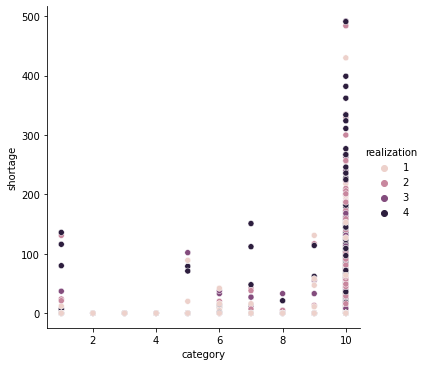

In [56]:
sns.relplot(x="category", y="shortage", hue="realization", data=X.loc[(X['sample'].isin([4, 5])) & (X['demand_rule'] == 84)]);



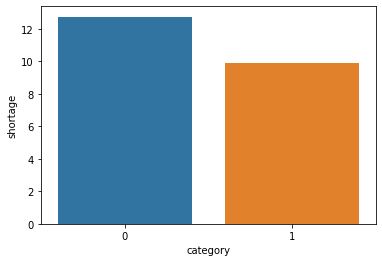

In [23]:
dxx_target = 'shortage'

dxx = X[[dxx_target, 'category']].groupby('category').mean()
dxx.reset_index(inplace=True)

ax = sns.barplot(x="category", y=dxx_target, data=dxx)



In [24]:
X.loc[X.category == 1].describe()

,sample,realization,demand_rule,demand,shortage,category
count,508800.000000,508800.000000,508800.00000,508800.000000,508800.000000,508800.0
mean,2.500000,2.500000,299.50000,93.797142,9.916219,1.0
std,1.118035,1.118035,173.20501,117.819814,32.401774,0.0
min,1.000000,1.000000,0.00000,0.000000,0.000000,1.0
25%,1.750000,1.750000,149.75000,0.000000,0.000000,1.0
50%,2.500000,2.500000,299.50000,0.000000,0.000000,1.0
75%,3.250000,3.250000,449.25000,182.000000,0.000000,1.0
max,4.000000,4.000000,599.00000,374.000000,228.000000,1.0


In [25]:
X['category'].value_counts()

0    11587200
1      508800
Name: category, dtype: int64

In [26]:
# remove 10
# X = X.loc[X['category'] < 10].copy()

In [39]:
target_y = 'category'

X_cols = ['demand_rule', 'shortage']

X_train, X_test, y_train, y_test = train_test_split(X[X_cols], X[target_y].values, test_size=0.2, random_state=0)


In [40]:
X_train.shape, X_test.shape

((9676800, 2), (2419200, 2))

In [41]:
# Fit the model
model = tree.DecisionTreeClassifier(criterion='gini', 
                                    splitter='best', 
                                    max_depth=4,
                                    class_weight=None,
                                    min_samples_leaf=1000, 
                                    random_state=0)
clf = model.fit(X_train, y_train)


In [42]:
# Predict class labels on training data
pred_labels_tr = model.predict(X_train)


In [43]:
# Predict class labels on a test data
pred_labels_te = model.predict(X_test)


In [44]:
# Tree summary and model evaluation metrics
print('*************** Tree Summary ***************')
print('Classes: ', clf.classes_)
print('Tree Depth: ', clf.tree_.max_depth)
print('No. of leaves: ', clf.tree_.n_leaves)
print('No. of features: ', clf.n_features_)
print('--------------------------------------------------------')
print("")

print('*************** Evaluation on Test Data ***************')
score_te = model.score(X_test, y_test)
print('Accuracy Score: ', score_te)
# Look at classification report to evaluate the model
print(classification_report(y_test, pred_labels_te))
print('--------------------------------------------------------')
print("")

print('*************** Evaluation on Training Data ***************')
score_tr = model.score(X_train, y_train)
print('Accuracy Score: ', score_tr)
# Look at classification report to evaluate the model
print(classification_report(y_train, pred_labels_tr))
print('--------------------------------------------------------')


*************** Tree Summary ***************
Classes:  [0 1]
Tree Depth:  4
No. of leaves:  15
No. of features:  2
--------------------------------------------------------

*************** Evaluation on Test Data ***************
Accuracy Score:  0.9579914847883598


/Users/d3y010/.pyenv/versions/py3.9.4_ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/d3y010/.pyenv/versions/py3.9.4_ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/d3y010/.pyenv/versions/py3.9.4_ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

              precision    recall  f1-score   support

           0       0.96      1.00      0.98   2317573
           1       0.00      0.00      0.00    101627

    accuracy                           0.96   2419200
   macro avg       0.48      0.50      0.49   2419200
weighted avg       0.92      0.96      0.94   2419200

--------------------------------------------------------

*************** Evaluation on Training Data ***************
Accuracy Score:  0.957922763723545


/Users/d3y010/.pyenv/versions/py3.9.4_ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/d3y010/.pyenv/versions/py3.9.4_ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.96      1.00      0.98   9269627
           1       0.00      0.00      0.00    407173

    accuracy                           0.96   9676800
   macro avg       0.48      0.50      0.49   9676800
weighted avg       0.92      0.96      0.94   9676800

--------------------------------------------------------


/Users/d3y010/.pyenv/versions/py3.9.4_ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [145]:
# Use graphviz to plot the tree
dot_data = tree.export_graphviz(clf, 
                                out_file=None, 
                            feature_names=X_cols, 
                            class_names=[str(i) for i in clf.classes_],
                            filled=True, 
                            rounded=True, 
                            #rotate=True,
                           ) 


In [146]:
graph = graphviz.Source(dot_data)

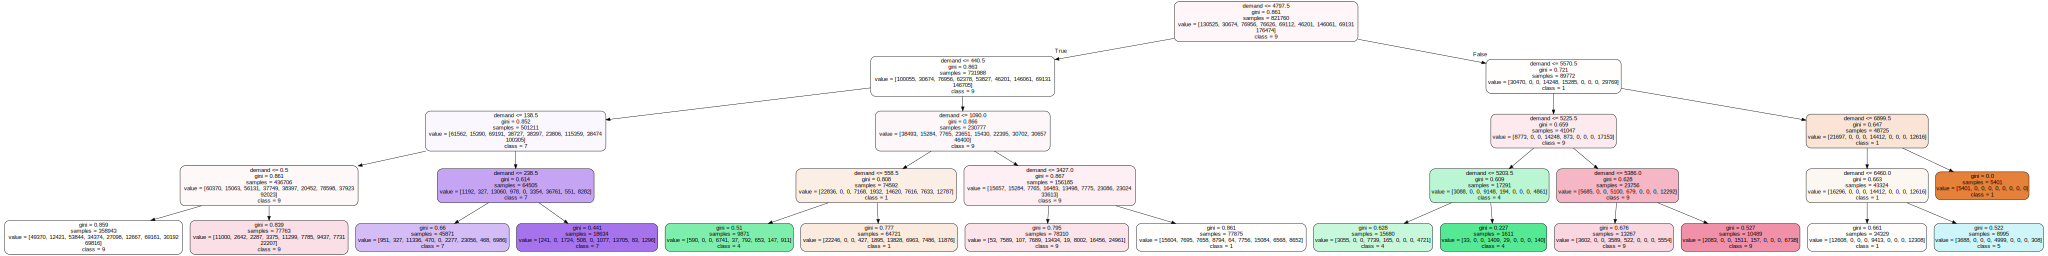

In [147]:
graph

In [35]:
# Fit the model and display results
X_train, X_test, y_train, y_test, clf, graph = fitting(X=X, 
                                                       y=X['category'].values, 
                                                       criterion='gini', 
                                                       splitter='best', 
                                                       mdepth=None, 
                                                       clweight=None,
                                                       minleaf=1000)


*************** Tree Summary ***************
Classes:  [ 1  2  3  4  5  6  7  8  9 10]
Tree Depth:  9
No. of leaves:  10
No. of features:  6
--------------------------------------------------------

*************** Evaluation on Test Data ***************
Accuracy Score:  1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     65081
           2       1.00      1.00      1.00     30587
           3       1.00      1.00      1.00     34641
           4       1.00      1.00      1.00     22853
           5       1.00      1.00      1.00     17160
           6       1.00      1.00      1.00     24874
           7       1.00      1.00      1.00     36550
           8       1.00      1.00      1.00     51921
           9       1.00      1.00      1.00     93930
          10       1.00      1.00      1.00   2041603

    accuracy                           1.00   2419200
   macro avg       1.00      1.00      1.00   2419200
weighted avg       1

IndexError: list index out of range

In [ ]:
graph


In [10]:

def fitting(X, y, criterion, splitter, mdepth, clweight, minleaf):

    # Create training and testing samples
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Fit the model
    model = tree.DecisionTreeClassifier(criterion=criterion, 
                                        splitter=splitter, 
                                        max_depth=mdepth,
                                        class_weight=clweight,
                                        min_samples_leaf=minleaf, 
                                        random_state=0, 
                                  )
    clf = model.fit(X_train, y_train)

    # Predict class labels on training data
    pred_labels_tr = model.predict(X_train)
    # Predict class labels on a test data
    pred_labels_te = model.predict(X_test)

    # Tree summary and model evaluation metrics
    print('*************** Tree Summary ***************')
    print('Classes: ', clf.classes_)
    print('Tree Depth: ', clf.tree_.max_depth)
    print('No. of leaves: ', clf.tree_.n_leaves)
    print('No. of features: ', clf.n_features_)
    print('--------------------------------------------------------')
    print("")
    
    print('*************** Evaluation on Test Data ***************')
    score_te = model.score(X_test, y_test)
    print('Accuracy Score: ', score_te)
    # Look at classification report to evaluate the model
    print(classification_report(y_test, pred_labels_te))
    print('--------------------------------------------------------')
    print("")
    
    print('*************** Evaluation on Training Data ***************')
    score_tr = model.score(X_train, y_train)
    print('Accuracy Score: ', score_tr)
    # Look at classification report to evaluate the model
    print(classification_report(y_train, pred_labels_tr))
    print('--------------------------------------------------------')
    
    # Use graphviz to plot the tree
    dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=X.columns, 
                                class_names=[str(list(clf.classes_)[0]), str(list(clf.classes_)[1])],
                                filled=True, 
                                rounded=True, 
                                #rotate=True,
                               ) 
    graph = graphviz.Source(dot_data)
    
    # Return relevant data for chart plotting
    return X_train, X_test, y_train, y_test, clf, graph


In [3]:

# Select data for modeling
X=df[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 
      'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',  
      'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainTodayFlag']]

y=df['RainTomorrowFlag'].values



In [6]:
# Fit the model and display results
X_train, X_test, y_train, y_test, clf, graph = fitting(X=X, 
                                                       y=y, 
                                                       criterion='gini', 
                                                       splitter='best', 
                                                       mdepth=3, 
                                                       clweight=None,
                                                       minleaf=1000)


*************** Tree Summary ***************
Classes:  [0 1]
Tree Depth:  3
No. of leaves:  8
No. of features:  17
--------------------------------------------------------

*************** Evaluation on Test Data ***************
Accuracy Score:  0.828439818559021
              precision    recall  f1-score   support

           0       0.84      0.97      0.90     22067
           1       0.76      0.34      0.47      6372

    accuracy                           0.83     28439
   macro avg       0.80      0.65      0.68     28439
weighted avg       0.82      0.83      0.80     28439

--------------------------------------------------------

*************** Evaluation on Training Data ***************
Accuracy Score:  0.8278214392460924
              precision    recall  f1-score   support

           0       0.83      0.97      0.90     88249
           1       0.76      0.34      0.47     25505

    accuracy                           0.83    113754
   macro avg       0.80      0.65    